# Can the outcome of a football match be predicted from public transport data?

<center> <h2> <i> An analysis brought to you by a covid-induced lack of premier league football</i> </h2> </center>

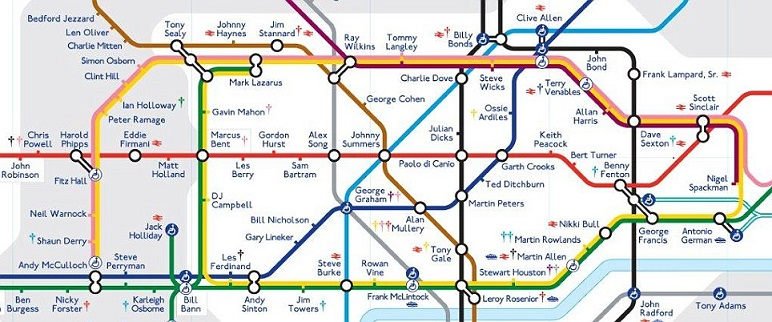

_Img. Source:_    [_150 - Year FA and TfL Anniversary Underground Map_](https://metro.co.uk/2013/10/02/football-association-launches-tube-map-to-mark-both-organisations-150th-anniversary-4132060/)

The London Undergound Network (hereinafter referred to by the _real_ name 'the tube') is the world's oldest rapid public transportation system, currently serving 270 stations and approx. 5 million passengers per day. In addition to a lot of tube stations, london also boasts a big variety of a different kind of english invention: Football Clubs. Apparently, next to the well known premier league instiutions, also several hundred [amateur clubs](https://en.wikipedia.org/wiki/Football_in_London#:~:text=London%20has%20several%20of%20England's,Football%20Association%20and%20the%20Amateur). 
<br>

Thanks to a [FOI Request](https://www.whatdotheyknow.com/request/daily_entry_and_exit_of_all_tube), 15-min interval station-specific entry/exit data for the london underground is publicily available. Out of the endless possible applications of this interesting dataset, the suspension of the premier league in it's final phase makes me crave some 'form' of football - which led to the question: Can the results of premier league home matches by the london clubs be inferred from public transport data?  

Any follower of european football has seen images of prematurely emptying stadiums, which usually happens when the home team did not exactly perform to the fan's expectations. Conversly, the home crowd might still be chanting and singing well after the final whistle after a particularly important or exciting win. The temptation to stay around and have drinks at a local pub should, from my (anecdotal) experience, also correlate to the outcome of a match.


___
### Step 1 - Creating and preparing a match schedule
<br>
Let's start by collecting the fixture schedule and results tables of the 12/13, 13/14 and 14/15 EPL seasons from [here](https://datahub.io/sports-data/english-premier-league) :

In [3]:
import pandas as pd

season1415 = pd.read_csv("Fixture Schedule//season-1415.csv")
season1314 = pd.read_csv("Fixture Schedule//season-1314.csv")
season1213 = pd.read_csv("Fixture Schedule//season-1213.csv")

season1415 = season1415[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']]
season1314 = season1314[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']]
season1213 = season1213[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']]     # drop all other info

games  = season1213
games  = games.append(season1314, ignore_index = True)
games  = games.append(season1415, ignore_index = True)                        # collect as single file

games.head()


,Date,HomeTeam,AwayTeam,FTHG,FTAG
0,18/08/12,Arsenal,Sunderland,0,0
1,18/08/12,Fulham,Norwich,5,0
2,18/08/12,Newcastle,Tottenham,2,1
3,18/08/12,QPR,Swansea,0,5
4,18/08/12,Reading,Stoke,1,1


The london clubs in those three seasons **with a nearby tubestation** were: 

- Arsenal
- Chelsea
- Fulham
- Tottenham Hotspur
- West Ham 
- Queens Park Rangers

Hence we need to filter out the irrelevant clubs, restrict to dates within the TFL dataset and decide the outcome of each game:    

In [4]:
import numpy as np

games['Date'] = pd.to_datetime(games['Date'], dayfirst=True) 

games.insert(5, 'End', 'NI')

conditions = [
    (games['FTHG'] <  games['FTAG']),
    (games['FTHG'] >  games['FTAG']),
    (games['FTHG'] == games['FTAG'])
             ]

choices = ['A', 'H', 'D']

games['Result'] = np.select(conditions, choices)

games = games.query('HomeTeam in ["Arsenal", "West Ham", "Fulham", "Chelsea", "Tottenham", "QPR"]')
games = games[(games['Date'] <= '2014-12-31') & (games['Date'] >= '2013-01-01')]
games = games.reset_index(drop=True)


Sadly, the source linked before provides us with everything we need, except the specific start time of the match. 

While searching for a different source, the best alternative I could find is [this](http://offsite.thismonkey.com/fixtures/football/calendars_csv) calendar feature which provides start dates, but no outcomes - which leaves no other option than to load both and combine them as appropriate:

In [5]:
timeinfo1415 = pd.read_csv("Fixture Schedule//2014.csv", sep = ';')     # this one has a different format
timeinfo1314 = pd.read_csv("Fixture Schedule//English_Premier_League_fixture_for_2013_14.csv")
timeinfo1213 = pd.read_csv("Fixture Schedule//English_Premier_League_fixture_for_2012_13.csv")

timeinfo = timeinfo1213.append(timeinfo1314, ignore_index = True)
timeinfo['Start Date'] = pd.to_datetime(timeinfo['Start Date'], dayfirst=True) # restrict date
timeinfo = timeinfo[(timeinfo['Start Date'] <= '2014-12-31') & (timeinfo['Start Date'] >= '2013-01-01')]
timeinfo = timeinfo.reset_index(drop=True)

timeinfo1415 = timeinfo1415.reset_index(drop=True)
timeinfo.head()


,Subject,Start Date,Start Time,End Date,End Time,All day event,Reminder on/off,Reminder Date,Reminder Time,Categories,Description,Location,Show time as,Private
0,Swansea City 2 v Aston Villa 2 (EPL),2013-01-01,15:00:00,01/01/2013,17:00:00,False,False,NaN,NaN,English Premier League,NaN,Liberty Stadium,3,False
1,Wigan Athletic 0 v Manchester United 4 (EPL),2013-01-01,15:00:00,01/01/2013,17:00:00,False,False,NaN,NaN,English Premier League,NaN,DW Stadium,3,False
2,Tottenham Hotspur 3 v Reading 1 (EPL),2013-01-01,15:00:00,01/01/2013,17:00:00,False,False,NaN,NaN,English Premier League,NaN,White Hart Lane,3,False
3,West Ham United 2 v Norwich City 1 (EPL),2013-01-01,15:00:00,01/01/2013,17:00:00,False,False,NaN,NaN,English Premier League,NaN,Upton Park,3,False
4,Manchester City 3 v Stoke City 0 (EPL),2013-01-01,15:00:00,01/01/2013,17:00:00,False,False,NaN,NaN,English Premier League,NaN,Etihad Stadium,3,False


The next step is slightly convoluted. We need to match each entry in the right time information file to the corresponding match in the game file. 

The format of the calendar for season 14/15 is slightly different and we cant combine them straightforwardly, so we'll have to handle that one separately. 

Additionally the naming of the clubs between the two sources differs slightly (eg. Manchester City / Man City), which needs to be corrected as we match a games result to it's start time via the respective team names:

In [6]:
wordbag = timeinfo.Subject.str.split()                       # get 'bag of words' of home and away team names
wordbag_14_home = timeinfo1415.HomeTeam.str.split()
wordbag_14_away = timeinfo1415.AwayTeam.str.split()

for source in [wordbag, wordbag_14_home, wordbag_14_away]:   # correct the naming discrepancies 
    for row in source:
        if 'Manchester' in row:
            row.append('Man')
        if 'Bromwich' in row:
            row.append('Brom')
        if 'Queens' in row:
            row.append('QPR')
            
switch_file = max(timeinfo['Start Date'])                    # date at which we need to switch to other time info file

for i, match in games.iterrows():
    Home = str.split(match['HomeTeam'])
    Away = str.split(match['AwayTeam'])
    
    # check which time info file to use
    if ( (match['Date'] <= switch_file) ):
        idx = np.where([set(Home+Away).issubset(set(row)) for row in wordbag])[0]  # find the timeinfo index at which the 
        games.at[i, 'End'] = timeinfo.loc[idx, 'End Time'].values[0]            # team names coincide and get start time
        
    else:
        idx = np.where([set(Home).issubset(set(row_home)) and                      # else do the same for other year and format
                     set(Away).issubset(set(row_away)) for row_home, row_away in 
                     zip(wordbag_14_home, wordbag_14_away)])[0]
        games.at[i, 'End'] = timeinfo1415.loc[idx, 'Fin'].values[0]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(games)
    

,Date,HomeTeam,AwayTeam,FTHG,FTAG,End,Result
0,2013-01-01,Tottenham,Reading,3,1,17:00:00,H
1,2013-01-01,West Ham,Norwich,2,1,17:00:00,H
2,2013-01-02,Chelsea,QPR,0,1,21:45:00,A
3,2013-01-12,Fulham,Wigan,1,1,17:00:00,D
4,2013-01-12,QPR,Tottenham,0,0,17:00:00,D
5,2013-01-13,Arsenal,Man City,0,2,18:00:00,A
6,2013-01-16,Chelsea,Southampton,2,2,21:45:00,D
7,2013-01-19,West Ham,QPR,1,1,17:00:00,D
8,2013-01-20,Chelsea,Arsenal,2,1,15:30:00,H
9,2013-01-20,Tottenham,Man United,1,1,18:00:00,D


and with that, the actual football data is ready and we can move on to prepare the TFL data.
___

## Step 2 - Preparing the public transport data

TFL provides the data in .csv format, one for each month. That obviously makes it rather tedious to download and import.

In order to keep track of everything in a tidy format, dictionaries will prove very helpful.

Everything gets loaded into a dictionary that returns the correct dataframe for given month and year. An auxiliary function in the attached 'auxfun.py' helps convert the month abbrevations to integer labels, while keeping the code readable. We also drop most of the information in the csv and only consider entry counts at the stations closest to the respective stadiums.

In [7]:
FOI_REQ = ["JAN13", "FEB13", "MAR13", "APR13", "MAY13", "JUN13", 
           "JUL13", "AUG13", "SEP13", "OCT13", "NOV13", "DEC13",
           "Jan14", "Feb14", "Mar14", "Apr14", "May14", "Jun14",
           "Jul14", "Aug14", "Sep14", "Oct14", "Nov14", "Dec14"]
tfl_df  = {}

from auxfunctions import strtomon

for month in FOI_REQ:
    
    yr = 2013
    if "14" in month:
        yr = 2014        
    mon = strtomon(month)
        
    file = "TFL FOI REQ//" + month + ".csv"
    df = pd.read_csv(file, skiprows = 3)    
    df = df.query('Station in ["Arsenal", "East Ham", "Putney Bridge", \
                  "Fulham Broadway", "Seven Sisters", "White City"]')
    df = df[df['ent/ex'] == 'Entry Corr']
    df['date'] = pd.to_datetime(df['date'], dayfirst=True)
    
    tfl_df[mon, yr] = df
    

Since the headers of the TfL csv's are in the form 'hhmm-hhmm', we create another dictionary that matches every occuring end time to the corresponding string, and another dictionary matching each club to the corresponding underground station:

In [8]:
ends = games['End'].unique()

time_matching ={ends[0] : '1645-1700', ends[1] : '2130-2145', ends[2] : '1745-1800',
                ends[3] : '1515-1530', ends[4] : '2145-2200', ends[5] : '1915-1930',
                ends[6] : '2045-2100', ends[7] : '1545-1600', ends[8] : '1700-1715',
                ends[9] : '1500-1515', ends[10] : '2030-2045', ends[11] : '1415-1430',
                ends[12] : '1815-1830', ends[13] : '1330-1345', ends[14] : '1900-1915',
                ends[15] : '1630-1645', ends[16] : '1500-1515', ends[17] : '1415-1430',
                ends[18] : '1545-1600', ends[19] : '1530-1545', ends[20] : '1745-1800',
                ends[21] : '2130-2145', ends[22] : '1730-1745', ends[23] : '2115-2130',
                ends[24] : '1330-1345'}


station_matching = {'Arsenal' : 'Arsenal', 'Chelsea' : 'Fulham Broadway', 'Fulham' : 'Putney Bridge', 
                    'West Ham' : 'East Ham', 'Tottenham' : 'Seven Sisters', 'QPR' : 'White City'}


And we extract the weekday of each game, and prepare columns for the number of considered intervals after the end of the match:

In [9]:
entries = 3 * 4            
games['DoW'] = [date.dayofweek for date in games['Date']]

for i in range(entries):
    name = str(i * 15)
    games.insert(8 + i, name, 0)
    

Now the final import step requires matching and extracting the entrance count to the corresponding match. Additionally, we can already take care of the first preprocessing step. Matches take place during various times and days of the week - directly comparing the total entrance counts of thursday 6 pm and sunday 3 pm for f.e. Stratford Station has very little informational value.

So the first normalisation we require is a general normalisation of tube traffic. For each station, we calculate the mean of each time interval per week day (and month), and normalise the post-match entrance count by that mean. 

Since for some stations data is not available for every day of the week, a 'daymatching' function again from auxfuns.py returns the 'closest' available day (weekend to weekend and so forth) and normalises with respect to that.


In [77]:
from auxfunctions import daymatching

games_nml = games

for i, match in games.iterrows():
    
    df = tfl_df[match['Date'].month, match['Date'].year]     # gather the right df, station and end time
    station = station_matching[match['HomeTeam']]
    time    = time_matching[match['End']]
    
    data = df.loc[(df['Station'] == station) & (df['date'] == match['Date'])] # get the corr. entry data
    aux = df.loc[(df['Station'] == station)]                 # and an auxilliary frame for normalisation
                 
    if station is 'Seven Sisters':           
    # seven sisters has individual counts for different entrance portals
        data = df.loc[(df['Station'] == station) & (df['date'] == match['Date']) & (df['Location'] == 'TOTAL')]
        aux = df.loc[(df['Station'] == station) & (df['Location'] == 'TOTAL')]
        
    aux = aux.groupby(['day'], as_index = False).mean()      # use aux. frame to get means of each weekday
    avb_days = aux['day'].unique()                           # check if required day is available,
    DoW = daymatching(match['DoW'], avb_days)                # if not use the daymatching function
    
    aux_idx = aux.columns.get_loc(time)                      # get row and start idx of the time interval
    aux_row = aux.index[aux['day'] == DoW][0]
    
    idx = data.columns.get_loc(time)      

    games.loc[i, 8:8+entries] = data.iloc[0, idx:idx+entries].values # assign entry count data
    
    # normalise each count at each intervall with the corresponding
    # mean for that day of the week in that specific month
    nml = data.iloc[0, idx:idx+entries].values / aux.iloc[aux_row, aux_idx:aux_idx + entries]
    games_nml.loc[i,8:8+entries] = nml[0:entries].values

games_nml = games_nml[~games_nml.isin([np.nan, np.inf, -np.inf]).any(1)]       # drop rows with nan or inf values


Let's visualise some of the data. We will be looking at the 'relative' tube entrance count for all home games by Tottenham Hotspurs, and show two (admittedly handpicked) specific games that illustrate the behaviour that was initially hypothesised:

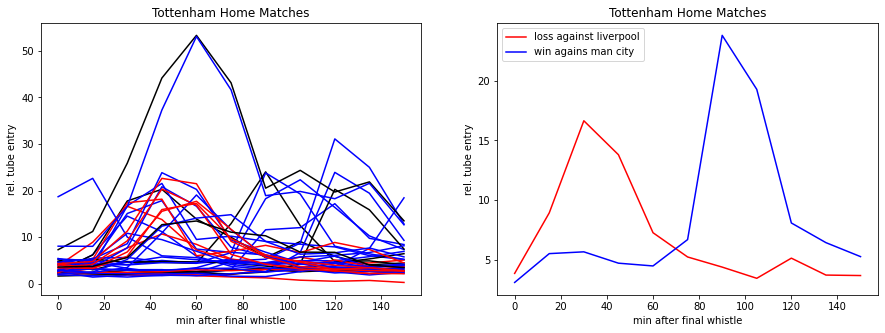

In [79]:
import matplotlib.pyplot as plt
%matplotlib inline
from warnings import filterwarnings
filterwarnings('ignore', category=DeprecationWarning)      # ignore LaTex rcparam depreciation warning


tottenham = games_nml[games_nml['HomeTeam'] == 'Tottenham']
index = np.array([0, 15, 30, 45, 60, 75, 90, 105, 120, 135, 150])

y = np.zeros(19)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))
ax1.set_title("Tottenham Home Matches")
for i, match in tottenham.iterrows():
    y = match[8:19]
    c = 'blue'
    if match[6] == 'A':
        c = 'red'
    elif match[6] == 'D':
        c = 'black'
    ax1.plot(index, y, color = c)
ax1.set_ylabel("rel. tube entry")
ax1.set_xlabel("min after final whistle")

intervals = ['0', '15', '30', '45', '60', '75', '90', '105', '120', '135', '150']

bigwin  = games_nml.query('HomeTeam == "Tottenham" and AwayTeam == "Liverpool" and Date == "2013-12-15"')
bigloss = games_nml.query('HomeTeam == "Tottenham" and AwayTeam == "Man City" and Date == "2013-04-21"')

ax2.plot(index, bigwin[intervals].values.reshape(11), 'r', label = "loss against liverpool")
ax2.plot(index, bigloss[intervals].values.reshape(11), 'b', label = "win agains man city")
ax2.legend(loc =0)
ax2.set_ylabel("rel. tube entry")
ax2.set_xlabel("min after final whistle")
ax2.set_title("Tottenham Home Matches")

filterwarnings('default', category=DeprecationWarning)


As we can see the data is still very noisy and requires further preprocessing. 

A key thing to consider is that different clubs have different stadium capacity (Tottenham's White Hart Lane sits 36000 while Craven Cottage can only sit 26000) and varying attendandce rates per game - which speaks against using a standard auto scaler, instead calling for the calculation of scale parameters ($\mu$ and $\sigma$) for each individual home team.

Given the idea of a measurable impact on transport usage of a 'sentiment' difference between game outcomes, a natural choice would be to normalise according to the travel patterns of drawn matches. This provides a good baseline both in terms of post-match sentiment and the required team-by-team correction for stadium capacity and attendance rate.

In order to verify the effectiveness of a 'draw norm', we'll also compute scale parameters using all available matches for each given team and compare them later on:

In [12]:
teams = list(games['HomeTeam'].unique())
intervals = list(games.columns[8:-1])

draw_norm = {}
team_norm = {}

for team in teams:
    
    wins = games[(games['HomeTeam'] == team) & (games["Result"] == 'H')].count()["Result"]
    losses = games[(games['HomeTeam'] == team) & (games["Result"] == 'A')].count()["Result"]
    draws = games[(games['HomeTeam'] == team) & (games["Result"] == 'D')].count()["Result"]
    
    print(team)
    print('wins:', wins, 'losses:', losses, 'draws:', draws)
    
    for time in intervals:
    # draw norm
        mean = ( 
            games_nml[(games_nml['HomeTeam'] == team) & (games_nml["Result"] == 'D')].sum()[time] / 
            games_nml[(games_nml['HomeTeam'] == team) & (games_nml["Result"] == 'D')].count()[time] 
            )
        draw_norm[team, time, 'mean'] = mean
        
        sde = ( 
            games_nml[(games_nml['HomeTeam'] == team) & (games_nml["Result"] == 'D')].std()[time] 
            )
        draw_norm[team, time, 'sde'] = sde
        
    # team norm
        mean = ( 
            games_nml[(games_nml['HomeTeam'] == team) & (games_nml["Result"] != 'D')].sum()[time] / 
            games_nml[(games_nml['HomeTeam'] == team) & (games_nml["Result"] != 'D')].count()[time] 
            )
        team_norm[team, time, 'mean'] = mean
        
        sde = ( 
            games_nml[(games_nml['HomeTeam'] == team) & (games_nml["Result"] != 'D')].std()[time] 
            )
        team_norm[team, time, 'sde'] = sde


Tottenham
wins: 21 losses: 10 draws: 7
West Ham
wins: 18 losses: 13 draws: 7
Chelsea
wins: 31 losses: 2 draws: 5
Fulham
wins: 8 losses: 16 draws: 4
QPR
wins: 6 losses: 6 draws: 7
Arsenal
wins: 24 losses: 3 draws: 11


As we can see the dataset is per se imbalanced towards home wins. Any train/test splits of the data will have to be stratified in order to guarantee a representative mixture of observations, and we will further consider downsampling at a later stage.

Sadly, no TfL data for any more recent years are available - Arsenal thankfully did their best to help adress the win/loss imbalance, so hopefully TfL will release more in the near future.

We now create the final normalised datasets via the standard scaling
$$ z_i  = \frac{x_i-\mu}{\sigma} $$

for the two sets of scale parameters outlined above:

In [13]:
pd.options.mode.chained_assignment = None  # default='warn'

df_drawnorm = games_nml[games_nml['Result'] != 'D']
df_drawnorm['Result'] = df_drawnorm['Result'].replace(to_replace = ['H', 'A'], value = [1, -1])

for idx, row in df_drawnorm.iterrows():
    for time in intervals:
        df_drawnorm.loc[idx, time] = (df_drawnorm.loc[idx, time] - draw_norm[row['HomeTeam'], time, 'mean']) \
                                     / draw_norm[row['HomeTeam'], time, 'sde']
        
df_teamnorm = games_nml[games_nml['Result'] != 'D']
df_teamnorm['Result'] = df_teamnorm['Result'].replace(to_replace = ['H', 'A'], value = [1, -1])

for idx, row in df_teamnorm.iterrows():
    for time in intervals:
        df_teamnorm.loc[idx, time] = (df_teamnorm.loc[idx, time] - team_norm[row['HomeTeam'], time, 'mean']) \
                                     / team_norm[row['HomeTeam'], time, 'sde']
    

and with that the TfL data is ready to use and we can start developing our classifier!

___

### Part 3 - Developing a Classifier Algorithm

Several of the most commonly used classification algorithms (SVM, GNB, LogReg) rely on the assumption of feature independence - strictly speaking independent and identically distributed - which quite obviously is rarely given in the analysis of time series. One can still apply them and obtain great results, particularly using neural networks, but should always be aware that the mathematical foundation of the analysis could be flawed. Help is available in the form of several sophisticated frameworks (f.e. hidden markov models, ARIMA) and a variety of statistical data transformations.

One of the simplest transformations for non-stationary data is given by differencing:

$$\hat y_t = y_t - y_{t-1}$$

Which helps stabilize the mean of a time series. Luckily the tube entrance counts we are given are already a differenced series; the data provides us with the difference between total tube station entries at time $t$ and $t-1$ - while not perfect, we can therefore calmly but carefully apply some standard classification algorithms. 

As mentioned before, neural networks in particular have been applied very succesfully to time-series problems (and most other DS problems to be honest) and so we will too particularly focus on a multi-layer perceptron algorithm for this problem.

For a small size application like this a single hidden layer is more than sufficient. A good rule of thumb for the number of hidden neurons is given as the mean of the input (11) and output(2) neurons, giving us 6 hidden neurons. As computational resources will not be a factor on such a small dataset, we'll use the hyperbolic tangens as activation function - which is well suited for problems with inputs of varying size and sign.

Let's compute the receiver-operating characteristics and a confusion matrix for the first MLP classifier:

true positive 17 true negative 4
false positve 6 false negative 3
Accuracy: 0.70
AUC: 0.77


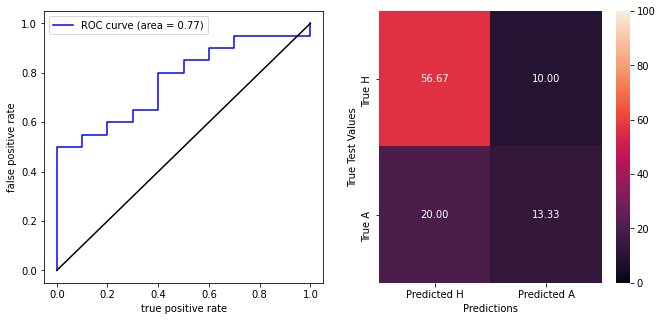

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns

filterwarnings('ignore')

y = df_drawnorm['Result']
x = df_drawnorm[intervals]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify = y, random_state = 42)

clf = MLPClassifier(hidden_layer_sizes = (6), activation = 'tanh',
                    random_state = 42 ).fit(X_train, y_train)

y_pred = clf.predict(X_test)
probs = clf.predict_proba(X_test)

def check_classifier(y_test, y_pred, probs):
    fpr, tpr, _ = roc_curve(y_test, probs[:,1])
    roc_auc = roc_auc_score(y_test, probs[:,1])

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    conf_arr = np.array([[tp, fn],[fp,tn,]])
    conf_arr = conf_arr / conf_arr.sum() * 100
    cm = pd.DataFrame(conf_arr, index = [ 'True H', 'True A'], columns = ['Predicted H', 'Predicted A'])

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,5))
    ax1.plot(fpr, tpr, 'b', label='ROC curve (area = %0.2f)' % roc_auc)
    ax1.plot(fpr, fpr, 'k-')
    ax1.legend()
    sns.heatmap(cm, annot=True, vmin=0.0, vmax=100.0, fmt='.2f',  ax = ax2)
    ax2.set_xlabel("Predictions")
    ax2.set_ylabel("True Test Values")
    ax1.set_xlabel("true positive rate")
    ax1.set_ylabel("false positive rate")
    print('true positive', tp, 'true negative', tn)
    print('false positve', fp, 'false negative', fn)
    print('Accuracy: %0.2f' % ((tp+tn)/(tp+tn+fp+fn)))
    print('AUC: %0.2f' % roc_auc)
    
    return

check_classifier(y_test, y_pred, probs)


which is 'relatively' good! But that is another handpicked result for a particularly well performing initial random state (controlling the way in which the data is split into a test and training set). 

We get a more accurate impression of the accuracy of the MLP classifier when using 5-fold crossvalidation:

In [16]:
from sklearn.model_selection import cross_val_score

clf = MLPClassifier(hidden_layer_sizes = (6), activation = 'tanh',
                    random_state = None)
scores = cross_val_score(clf, x, y, cv=3)
print('accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))


accuracy: 0.66 (+/- 0.09)


With the accuracy being definetly above >50%, we can conclude that indeed there is some inferrable information about match outcomes hidden in the tube patterns.

Let's check if using draws to find the normalisation parameters was indeed a good choice:

true positive 19 true negative 1
false positve 9 false negative 1
Accuracy: 0.67
AUC: 0.60
cross validation accuracy: 0.53 (+/- 0.28)


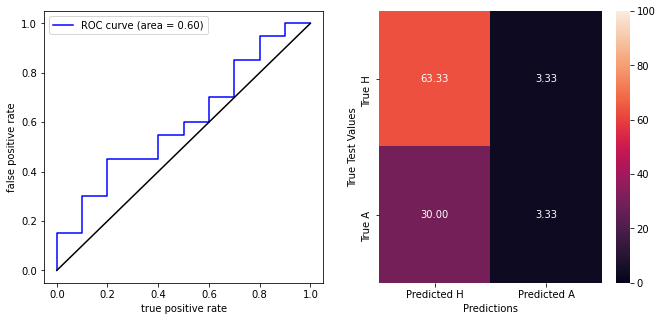

In [17]:
y = df_teamnorm['Result']
x = df_teamnorm[intervals]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify = y, random_state = 42)

clf = MLPClassifier(hidden_layer_sizes = (6), activation = 'tanh',
                    random_state = 42 ).fit(X_train, y_train)

y_pred = clf.predict(X_test)
probs = clf.predict_proba(X_test)

check_classifier(y_test, y_pred, probs)
clf = MLPClassifier(hidden_layer_sizes = (6), activation = 'tanh',
                    random_state = None)
scores = cross_val_score(clf, x, y, cv=5)
print('cross validation accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))


which makes the draw norm look like the right idea. However, I believe we can still push the accuracy and AUC higher. 

An obvious way to do so would be to provide more information by including additional features - like a one hot encoding of the home team. Considering the initially posed question was solely focusing on inferences from tube patterns, the inclusion of the station would be an information leak and distract from the core hypothesis - I will not include any more features to increase classifier performance.

Also, i tried it out and it did in fact decrease accuracy; my suspicion is overfitting to the one hot encoded features due to their strong correlation with the outcomes. Simply knowing that the game in question was a Fulham home game implies $\approx \frac{2}{3}$ probability of a loss. I will attempt to implement a LIMA feature importance analysis when I'm back in London.

Instead let's go back to the win/loss imbalance. We can clearly see from the confusion matrix that we're getting a lot of false positives. A possible approach would be to perform downsampling such as to train the MLPCLF on an equivalent ratio of wins/losses by dropping random wins. This can be done easily one larger datasets, but will reduce our available training data by 37%. 

We will have to see wether the even outcome ratio can make up for the reduction in training data:

true positive 8 true negative 9
false positve 1 false negative 2
Accuracy: 0.85
AUC: 0.84


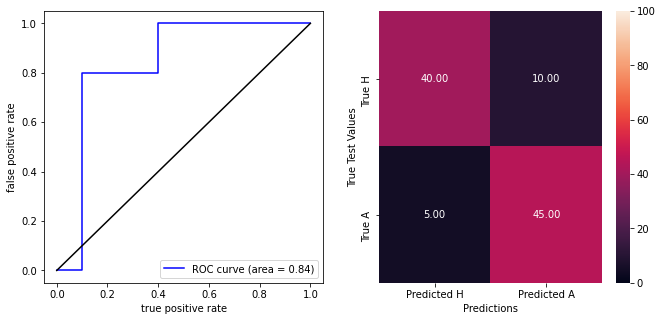

In [65]:
n_losses = len(df_drawnorm[df_drawnorm['Result'] == -1])
losses = df_drawnorm[df_drawnorm['Result'] == -1]
wins  = df_drawnorm[df_drawnorm['Result'] == 1].sample(n = n_losses)
df_downsampled = pd.concat([wins, losses], axis=0).sample(frac = 1).reset_index(drop=True)

y = df_downsampled['Result']
x = df_downsampled[intervals]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = None)

clf = MLPClassifier(hidden_layer_sizes = (6), activation = 'tanh',
                    random_state = 42 ).fit(X_train, y_train)

y_pred = clf.predict(X_test)
probs = clf.predict_proba(X_test)
check_classifier(y_test, y_pred, probs)


which does indeed look great! Let's recheck the accuracy using crossvalidation, this time 3-fold instead of 5-fold cv due to the smaller dataset:

In [57]:
clf = MLPClassifier(hidden_layer_sizes = (6), activation = 'tanh',
                    random_state = None)
scores = cross_val_score(clf, x, y, cv=5)
print('accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))


accuracy: 0.65 (+/- 0.19)


The cross validated accuracy on the downsampled dataset has decreased and variance strongly increased. We can run some diagnostics to look for possible sources of the high variance:

In [20]:
from sklearn.model_selection import cross_val_predict
from collections import Counter
y = df_downsampled['Result']
x = df_downsampled[intervals]
y_pred = cross_val_predict(clf, x, y, cv=3)
false = [df_downsampled.loc[x,:] for x in np.where(y_pred != y)]
Counter(false[0]['HomeTeam'])


Counter({'West Ham': 15,
         'Arsenal': 8,
         'Tottenham': 12,
         'Chelsea': 5,
         'Fulham': 8,
         'QPR': 7})

the classifier seems to particularly struggle with West Ham United. While Upton Park Station is incredibly close to Upton Park, West Ham in particular has a very strong local fanbase - who likely don't require the district line to get home.

let's also peek at the performance of a support vector machine and a random forest. Particularly the support vector machine is theoretically not suitable for this differenced time series application, but will give us a benchmark for the next approach: 

In [67]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

clf = svm.SVC(gamma = 'auto')
scores = cross_val_score(clf, x, y, cv=5)
print('SVM')
print('accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

print('-'*45)

clf = RandomForestClassifier(n_estimators = 64)
scores = cross_val_score(clf, x, y, cv=5)
print('Random Forest')
print('accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))


SVM
accuracy: 0.63 (+/- 0.13)
---------------------------------------------
Random Forest
accuracy: 0.61 (+/- 0.21)


This does not look good and will require some work. Here follows an attempt inspired by an IEEE paper.
___
## Part 4 - a specific signal classification approach

This [IEEE paper](https://ieeexplore.ieee.org/document/5489853) proposes an interesting kernel-induced random forest classification approach for electric singal classification with particular focus on the 'shape' of the curve based on a B-Spline regression and a custom kernel.

Given $n$ observations of some noisy signal $ y_{ij}=x_{i}(t_{ij})+\epsilon_{ij}$ they find a representation of $y$ as a linear combination of several cubic B-Spline regressions like 

$$x_{i}(t)=\sum_{k=1}^{K_{i}} \ c_{ik}\phi_{ik}(t)={\rm c}_{i}^{T}\phi_{i}(t)$$

Using the penalized sum squared error as loss function for some non-zero smoothing parameter $s$. They then define a kernel $\kappa(x_j, x_i)$ giving a measure of dissimilarity between curves which, for focus on shape features of the signals, takes the form:

$$\kappa(x_{i}(t),\ x_{j}(t))=\int[{d^p\over dt^{p}}x_{i}(t)-{d^p\over dt^{p}}x_{j}(t)]^{2}dt$$

which can then be used to train a random forest with a split rule

$$\kappa(x_{i}(t),\ \cdot)\ <  ?\$$

Implementation of a custom random forest kernel would require writing my own random forest implementation - which I will begin when I have some spare time at the start of uni. For now lets visualise the process for two curves from our dataset:

Result:
The p=1 kernel of curve 1 and 2 is 0.1826


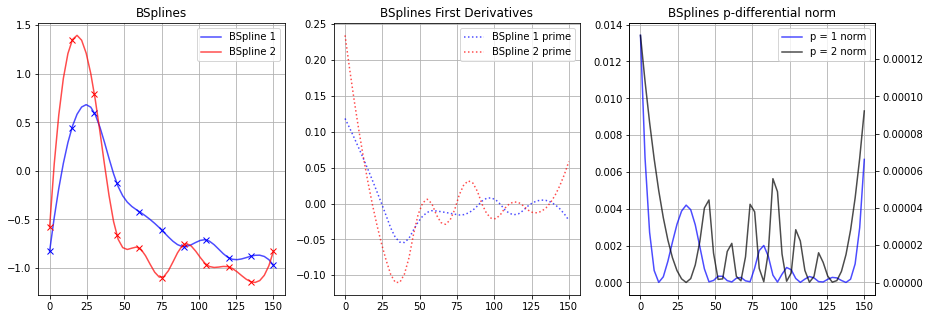

In [81]:
import scipy.interpolate as interpolate
from scipy.interpolate import BSpline

# take first and second signals and perform b-spline regression
y_1 = df_drawnorm.loc[0, intervals]
y_2 = df_drawnorm.loc[1, intervals]
x = np.array([0, 15, 30, 45, 60, 75, 90, 105, 120, 135, 150])

t_1, c_1, k_1 = interpolate.splrep(x, y_1, w=None, k=3)
t_2, c_2, k_2 = interpolate.splrep(x, y_2, w=None, k=3)

spl_1 = BSpline(t_1, c_1, k_1)
spl_2 = BSpline(t_2, c_2, k_2)

# plot the B-Splines
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,5))
xx = np.linspace(0, 150, 50)
ax1.plot(xx, spl_1(xx), 'b', alpha=0.7, label='BSpline 1')
ax1.plot(x, y_1, 'bx')
ax1.plot(xx, spl_2(xx), 'r', alpha=0.7, label='BSpline 2')
ax1.plot(x, y_2, 'rx')
ax1.grid(True)
ax1.legend(loc='best')
ax1.set_title('BSplines')

# plot their derivatives
spl1_prime = BSpline.derivative(spl_1, nu=1)
spl2_prime = BSpline.derivative(spl_2, nu=1)
ax2.plot(xx, spl1_prime(xx), 'b:', alpha=0.7, label='BSpline 1 prime')
ax2.plot(xx, spl2_prime(xx), 'r:', alpha=0.7, label='BSpline 2 prime')
ax2.grid(True)
ax2.legend(loc='best')
ax2.set_title('BSplines First Derivatives')

# find and plot the squarred p-diff norm
spl1_2 = BSpline.derivative(spl_1, nu=2)
spl2_2 = BSpline.derivative(spl_2, nu=2)

pdiff1 = (spl1_prime(xx) - spl2_prime(xx)) **2
pdiff2 = (spl1_2(xx) - spl2_2(xx)) **2

ax33 = ax3.twinx()
lns1 = ax3.plot(xx, pdiff1, 'b-', alpha=0.7, label='p = 1 norm')
lns2 = ax33.plot(xx, pdiff2, 'k-', alpha=0.7, label='p = 2 norm')
ax3.grid(True)
ax3.set_title('BSplines p-differential norm')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax3.legend(lns, labs, loc=0)

## calculate the p = 1 kernel 
y_n = spl1_prime(xx) - spl2_prime(xx)
t, c, k = interpolate.splrep(xx, y_n**2, w=None, k=3)
spl = BSpline(t, c, k)
int_1 = BSpline.integrate(spl, 0, 150, extrapolate=None)
print('Result:')
print('The p=1 kernel of curve 1 and 2 is %0.4f' % int_1)

We can however attempt to apply the approach in a very simplified manner.

We compute a Kernel Matrix $(i \times j)$ for $p$ being one and two and set the smoothing parameter to zero (forcing the curves to go through the exact knot points - the specific tube entry counts), where $i,j$ are the number of observations $m$. The resulting matrix contains 'dissimilarity' scores for each curve $x_i$ on row $i$ to curve $x_j$ in entry $K(i,j)$: 

In [23]:
def KernelMatrix(df, order = 1, s = 0):
    
    df = df.reset_index()
    intervals = ['0', '15', '30', '45', '60', '75', '90', '105', '120', '135', '150']
    x = np.array([0, 15, 30, 45, 60, 75, 90, 105, 120, 135, 150])
    
    # define square kernel matrix K(i,j) with i, j = len(df)
    KM = np.zeros((len(df), len(df)))
    
    # define evaluation set 
    xx = np.linspace(0, 150, 300)
    
    # iterate over observations using index i
    for i, row in df.iterrows():
        
        # create B-spline representation of obsv i
        y_i = row[intervals].to_numpy()
        t, c, k = interpolate.splrep(x, y_i, w=None, k=3, s = s)
        spl_i = BSpline(t, c, k)
        
        # iterate over observations using index j
        for j, row2 in df.iterrows():
            
            # create B-spline representation of obsv j
            y_j = row2[intervals]
            t_j, c_j, k_j = interpolate.splrep(x, y_j, w=None, k=3, s = s)
            spl_j = BSpline(t_j, c_j, k_j)
            
            # compute first derivative of b-spline i,j 
            spl_i_prime = BSpline.derivative(spl_i, nu=order)
            spl_j_prime = BSpline.derivative(spl_j, nu=order)
            
            # evaluate (spl_i_prime - spl_j_prime)**2 on xx,
            # find the new spline s = (s_i' - s_j')**2
            y_norm = (spl_i_prime(xx) - spl_j_prime(xx))**2
            t_n, c_n, k_n = interpolate.splrep(xx, y_norm, w=None, k=3)
            spl_n = BSpline(t_n, c_n, k_n)
            
            # evaluate the kernel by integrating spl_n on [0, 150]
            K = BSpline.integrate(spl_n, 0, 150, extrapolate=None)
            KM[i,j] = K
            
    return KM

KM1 = KernelMatrix(df_drawnorm, order = 1, s = 0)
KM2 = KernelMatrix(df_drawnorm, order = 2, s = 0)


and visualise the distribution of similarity scores by result for a random won game and lost game:

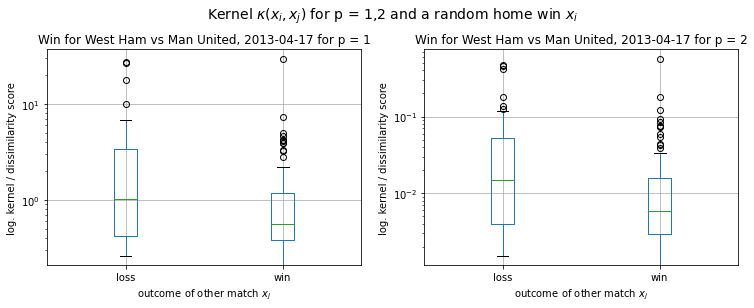

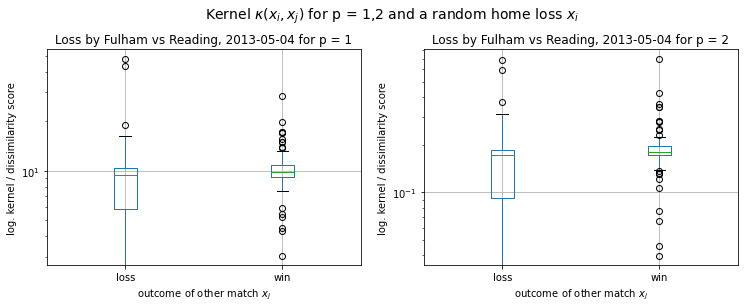

In [83]:
df_drawnorm = df_drawnorm.reset_index(drop = True)
random_win = df_drawnorm[df_drawnorm['Result'] == 1].sample(1).index.astype(int)[0]
random_loss = df_drawnorm[df_drawnorm['Result'] == -1].sample(1).index.astype(int)[0]
y = df_drawnorm['Result']

fig, axes = plt.subplots(1, 2, figsize = (12,4))
k = [KM1, KM2]
tit = ["for p = 1", "for p = 2"]
i = 0
for ax in axes.reshape(-1):
    km = k[i]
    kernel = pd.concat([pd.Series(km[random_win, :]), y], axis = 1)
    kernel = kernel.rename(columns={0: "Kernel", 1: "Result"})
    kernel.boxplot(by ='Result', ax=ax)
    ax.set_xlabel(r'outcome of other match $x_j$')
    title = 'Win for ' + games['HomeTeam'][random_win] + ' vs ' + games['AwayTeam'][random_win] \
            + ', ' + str(games['Date'][random_win].date()) + ' ' + tit[i]
    ax.set_title(title)
    ax.set_xticklabels(['loss', 'win'])
    ax.set_ylabel("log. kernel / dissimilarity score")
    ax.set_yscale('log')
    i += 1
fig.suptitle(r'Kernel $\kappa(x_i, x_j)$ for p = 1,2 and a random home win $x_i$', fontsize=14, y = 1.05)

fig, axes = plt.subplots(1, 2, figsize = (12,4))
i = 0
for ax in axes.reshape(-1):
    km = k[i]
    kernel = pd.concat([pd.Series(km[random_loss, :]), y], axis = 1)
    kernel = kernel.rename(columns={0: "Kernel", 1: "Result"})
    kernel.boxplot(by ='Result', ax=ax)
    ax.set_xlabel(r'outcome of other match $x_j$')
    title = 'Loss by ' + games['HomeTeam'][random_loss] + ' vs ' + games['AwayTeam'][random_loss] \
            + ', ' + str(games['Date'][random_loss].date()) + ' ' + tit[i]
    ax.set_title(title)
    ax.set_xticklabels(['loss', 'win'])
    ax.set_ylabel("log. kernel / dissimilarity score")
    ax.set_yscale('log')
    i += 1
fig.suptitle(r'Kernel $\kappa(x_i, x_j)$ for p = 1,2 and a random home loss $x_i$', fontsize=14, y = 1.05);
    

While the distributions are similiar and have a large number of outliers, there clearly is some difference - and it is more pronounced in the p = 2 kernel. Let's see if this difference can be exploited for classification - with the additional benefit that we are *not* dealing with time series data anymore!

We start again with a MLP classifier for the p=2 kernel using the same design heuristics:

true positive 18 true negative 3
false positve 7 false negative 2
Accuracy: 0.70
AUC: 0.83
cross validated accuracy: 0.71 (+/- 0.13)


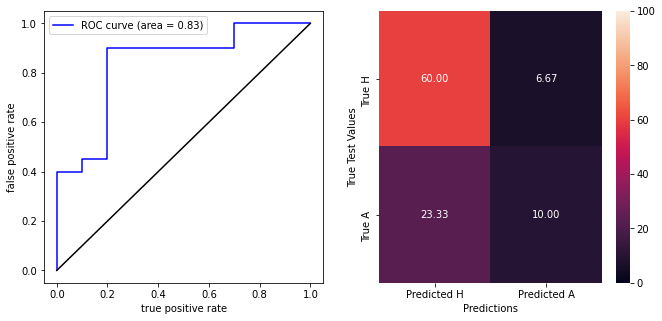

In [71]:
X_train, X_test, y_train, y_test = train_test_split(KM2, y, test_size=0.2, stratify = y, random_state = None)

clf = MLPClassifier(hidden_layer_sizes = (80), activation = 'tanh',
                    random_state = None ).fit(X_train, y_train)

y_pred = clf.predict(X_test)
probs = clf.predict_proba(X_test)

check_classifier(y_test, y_pred, probs)

scores = cross_val_score(clf, KM2, y, cv=5)
print('cross validated accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))


Which is a good result. Cross-validated accuracy increased at decreased variance! The imbalance problem is back again as we have not used the downsampled dataset, resulting in a high rate of false positives.

With the new format of the information a support vector machine might also work. The default implementation applies another radial basis function kernel. This is important as our kernel function is not a true kernel function. A kernel function is an inner product, and therefore must return a positive non-zero results when applied to identical elements, whereas our function would return 0 in such a case. Simplified, our kernel is a measure of dissimilarity, but we require a measure of similarity - which the RBF Kernel computes for us.

let's evaluate it for both kernels:

In [72]:
from sklearn import svm

clf = svm.SVC(gamma = 'auto')
scores = cross_val_score(clf, KM1, y, cv=5)
print('SVM for p = 1')
print('accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2)) 

print('-'*45)

clf = svm.SVC(gamma = 'auto')
scores = cross_val_score(clf, KM2, y, cv=5)
print('SVM for p = 2')
print('accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2)) 


SVM for p = 1
accuracy: 0.67 (+/- 0.12)
---------------------------------------------
SVM for p = 2
accuracy: 0.67 (+/- 0.02)


Definetly an improvement to the time series data! It is very interesting that both return the same mean accuracy, but the p = 2 kernel does so at much lower variance. The second derivative corresponds to the curvature or convexity of a function, and we can hence interpret the p = 2 kernel of two functions as the total square difference of their curvature, which does feel intuitive from our initial hypothesis. 

However curvature depends less on the magnitude of the function values than the first derivative, the local geometric slope, does - the lower variance might results from features being closer in magnitude (an unwitting 'scaling' on my part). The difference might be reduced by working out a new appropriate scaling for the kernel - maybe I will find time for that when term starts. 


Let's finally also try a Random Forest:

In [76]:
clf = RandomForestClassifier(n_estimators = 68)
scores = cross_val_score(clf, KM1, y, cv=5)
print('Random Forest for p = 1')
print('accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

print('-'*45)

clf = RandomForestClassifier(n_estimators = 68)
scores = cross_val_score(clf, KM2, y, cv=5)
print('Random Forest for p = 2')
print('accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))


Random Forest for p = 1
accuracy: 0.65 (+/- 0.13)
---------------------------------------------
Random Forest for p = 2
accuracy: 0.73 (+/- 0.14)


Absolutely an improvement on the prior RF result.

___

### SECTION STILL IN WORK

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import scipy.sparse

hometeam = df_drawnorm['HomeTeam'].to_numpy().reshape(-1,1)

onehotencoder = OneHotEncoder()
transformed = onehotencoder.fit_transform(hometeam)

transformed = pd.DataFrame.sparse.from_spmatrix(transformed)
transformed = transformed.rename(columns={0: "Arsenal", 1: "Chelsea", 2: 'Fulham', 
                                         3: 'QPR', 4: 'Tottenham', 5: 'West Ham'})

df_drawnorm = pd.concat([df_drawnorm.reset_index(drop = True), transformed.reset_index(drop = True)], axis=1)


features = intervals + ['Chelsea', 'Arsenal', 'QPR', 'Fulham', 'Tottenham']
y = df_drawnorm['Result']
x = df_drawnorm[features]

clf = MLPClassifier(hidden_layer_sizes = (6), activation = 'tanh',
                    random_state = 42)
scores = cross_val_score(clf, x, y, cv=5)
print('MLP with one-hot encoded home team')
print('accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))
